In [1]:
import pandas as pd
import numpy as np
from zipfile import ZipFile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,roc_auc_score
from tensorflow.python.client import device_lib
from keras import backend as K
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from sklearn.metrics import mean_absolute_error




In [2]:
movielens_dir = "../ml-25m/"
ratings_file = movielens_dir + "ratings.csv"
df = pd.read_csv(ratings_file)


In [3]:
df

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510
...,...,...,...,...
25000090,162541,50872,4.5,1240953372
25000091,162541,55768,2.5,1240951998
25000092,162541,56176,2.0,1240950697
25000093,162541,58559,4.0,1240953434


In [4]:
##df = df.sample(n = 1000000)
user_ids = df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
df["user"] = df["userId"].map(user2user_encoded)
df["movie"] = df["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
df["rating"] = df["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(df["rating"])
max_rating = max(df["rating"])



print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

Number of users: 162541, Number of Movies: 59047, Min rating: 0.5, Max rating: 5.0


In [5]:
df

,userId,movieId,rating,timestamp,user,movie
0,1,296,5.0,1147880044,0,0
1,1,306,3.5,1147868817,0,1
2,1,307,5.0,1147868828,0,2
3,1,665,5.0,1147878820,0,3
4,1,899,3.5,1147868510,0,4
...,...,...,...,...,...,...
25000090,162541,50872,4.5,1240953372,162540,544
25000091,162541,55768,2.5,1240951998,162540,4574
25000092,162541,56176,2.0,1240950697,162540,7115
25000093,162541,58559,4.0,1240953434,162540,578


In [6]:
df = df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 90% of the data and validating on 10%.
train_indices = int(0.7 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)
print(len(x_train))
print(len(x_val))



17500066
7500029


## Modelo 2

In [28]:
# creating book embedding path
movie_input = layers.Input(shape=[1], name="Movie-Input")
movie_embedding = layers.Embedding(num_movies+1, 5, name="Movie-Embedding")(movie_input)
movie_vec = layers.Flatten(name="Flatten-Books")(movie_embedding)
# creating user embedding path
user_input = layers.Input(shape=[1], name="User-Input")
user_embedding = layers.Embedding(num_users+1, 5, name="User-Embedding")(user_input)
user_vec = layers.Flatten(name="Flatten-Users")(user_embedding)
# concatenate features
conc = layers.Concatenate()([movie_vec, user_vec])
# add fully-connected-layers
fc1 = layers.Dense(128, activation='relu')(conc)
fc2 = layers.Dense(32, activation='relu')(fc1)
out = layers.Dense(1)(fc2)
# Create model and compile it
model2 = Model([user_input, movie_input], out)
model2.compile('adam', 'mean_squared_error')


In [30]:

history = model2.fit(x=x_train, y=y_train, epochs=5, verbose=1, validation_data=(x_val, y_val))

pd.Series(history.history['loss']).plot(logy=True)
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

y_hat = np.round(model2.predict(x_val), decimals=2)
y_true = y_val
mean_absolute_error(y_true, y_hat)

Epoch 1/5


ValueError: in user code:

    File "C:\Users\Admin\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\Admin\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Admin\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\Admin\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\Admin\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Admin\AppData\Local\Programs\Python\Python37\lib\site-packages\keras\engine\input_spec.py", line 199, in assert_input_compatibility
        raise ValueError(f'Layer "{layer_name}" expects {len(input_spec)} input(s),'

    ValueError: Layer "model_11" expects 2 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 2) dtype=int64>]


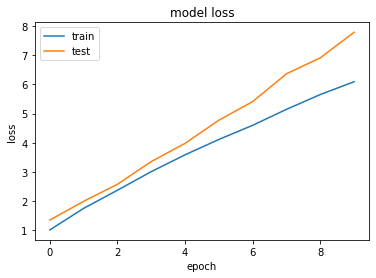

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
movie_df = pd.read_csv(movielens_dir + "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Mostrando las recomendaciones para el usuario: {}".format(user_id))
print("====" * 9)
print("Peliculas calificadas por el usuario")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 peliculas recomendadas")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Mostrando las recomendaciones para el usuario: 86795
Peliculas calificadas por el usuario
--------------------------------
Princess Bride, The (1987) : Action|Adventure|Comedy|Fantasy|Romance
Back to the Future Part II (1989) : Adventure|Comedy|Sci-Fi
American Beauty (1999) : Drama|Romance
Double Jeopardy (1999) : Action|Crime|Drama|Thriller
Gladiator (2000) : Action|Adventure|Drama
--------------------------------
Top 10 peliculas recomendadas
--------------------------------
African Queen, The (1951) : Adventure|Comedy|Romance|War
Shall We Dance? (Shall We Dansu?) (1996) : Comedy|Drama|Romance
Lock, Stock & Two Smoking Barrels (1998) : Comedy|Crime|Thriller
Professional, The (Le professionnel) (1981) : Action|Drama|Thriller
My Neighbor Totoro (Tonari no Totoro) (1988) : Animation|Children|Drama|Fantasy
Barton Fink (1991) : Drama|Thriller
Eddie Murphy Delirious (1983) : Comedy|Documentary
Dark Knight, The (2008) : Action|Crime|Drama|IMAX
Moonrise Kingdom (2012) : Comedy|Drama|Romance


In [ ]:
# Guardar el Modelo

model.save_weights("Modelo1SegundaPrueba", overwrite=True, save_format=None, options=None)



In [ ]:
# Cargar Modelo

model.load_weights("ModeloPrimeraPrueba", by_name=False, skip_mismatch=False, options=None)
model.summary()

Model: "recommender_net_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     multiple                  8127050   
                                                                 
 embedding_9 (Embedding)     multiple                  162541    
                                                                 
 embedding_10 (Embedding)    multiple                  2952350   
                                                                 
 embedding_11 (Embedding)    multiple                  59047     
                                                                 
Total params: 11,300,988
Trainable params: 11,300,988
Non-trainable params: 0
_________________________________________________________________


In [ ]:
movie_df = pd.read_csv(movielens_dir + "movies.csv")

# Let us get a user and see the top recommendations.
user_id = df.userId.sample(1).iloc[0]
movies_watched_by_user = df[df.userId == user_id]
movies_not_watched = movie_df[
    ~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)
]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]

print("Mostrando las recomendaciones para el usuario: {}".format(user_id))
print("====" * 9)
print("Peliculas calificadas por el usuario")
print("----" * 8)
top_movies_user = (
    movies_watched_by_user.sort_values(by="rating", ascending=False)
    .head(5)
    .movieId.values
)
movie_df_rows = movie_df[movie_df["movieId"].isin(top_movies_user)]
for row in movie_df_rows.itertuples():
    print(row.title, ":", row.genres)

print("----" * 8)
print("Top 10 peliculas recomendadas")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genres)

Mostrando las recomendaciones para el usuario: 28508
Peliculas calificadas por el usuario
--------------------------------
Godfather, The (1972) : Crime|Drama
One Flew Over the Cuckoo's Nest (1975) : Drama
Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) : Action|Adventure|Western
Boot, Das (Boat, The) (1981) : Action|Drama|War
Shining, The (1980) : Horror
--------------------------------
Top 10 peliculas recomendadas
--------------------------------
Ferris Bueller's Day Off (1986) : Comedy
Children of Paradise (Les enfants du paradis) (1945) : Drama|Romance
Drunken Master (Jui kuen) (1978) : Action|Comedy
Conformist, The (Conformista, Il) (1970) : Drama
Brief Encounter (1946) : Drama|Romance
Lady Eve, The (1941) : Comedy|Romance
Palm Beach Story, The (1942) : Comedy
Modern Times (1936) : Comedy|Drama|Romance
Hud (1963) : Drama|Western
Inherit the Wind (1960) : Drama
